# 06. Strategy Comparison & Statistical Analysis

This notebook provides comprehensive strategy comparison, statistical testing, and performance analysis for ML vs traditional trading strategies.


#### Overview
This notebook performs rigorous statistical analysis comparing:
- Traditional technical analysis strategies  
- Machine learning models
- Deep learning models
- Ensemble strategies

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
import json
from typing import Dict, List, Tuple, Optional, Any, Union
from scipy import stats
from scipy.stats import ttest_rel, mannwhitneyu, shapiro
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class Config:
    RESULTS_DIR = Path("notebooks/results")
    RESULTS_DIR.mkdir(exist_ok=True)
    
    # Analysis parameters
    CONFIDENCE_LEVEL = 0.95
    ALPHA = 0.05
    N_BOOTSTRAP = 1000
    MIN_SAMPLES = 30
    
    # Performance thresholds
    MIN_SHARPE = 0.5
    MAX_DRAWDOWN = 0.30
    
    # Production flags
    PRODUCTION_MODE = False
    DEBUG = False

config = Config()

In [3]:
def load_all_results():    
    results = {}
    
    # Load feature engineering data - check notebooks folder directly
    feature_file = Path("notebooks/03_feature_engineering_final.pkl")
    if not feature_file.exists():
        feature_file = Path("03_feature_engineering_final.pkl")
    
    if feature_file.exists():
        with open(feature_file, 'rb') as f:
            feature_data = pickle.load(f)
            results['features'] = feature_data
            print(f"Loaded feature engineering data")
    else:
        print(f"Feature engineering file not found: {feature_file}")
        
    # Load baseline strategies - check multiple possible files
    baseline_files = [
        Path("notebooks/04_COMPLETE_baseline_results.pkl"),
        Path("04_COMPLETE_baseline_results.pkl"),
        Path("notebooks/04_baseline_results_fixed.pkl"),
    ]
    
    baseline_data = None
    for baseline_file in baseline_files:
        if baseline_file.exists():
            try:
                with open(baseline_file, 'rb') as f:
                    baseline_data = pickle.load(f)
                    results['baseline'] = baseline_data
                    print(f"Loaded baseline strategies results from {baseline_file.name}")
                    break
            except Exception as e:
                print(f"Error loading {baseline_file}: {e}")
    
    if baseline_data is None:
        print(f"No baseline strategies file found")
    
    # Load ML models results - check notebooks folder
    ml_files = [
        Path("notebooks/results/05_ml_models_final.pkl"),
        Path("notebooks/05_ml_models_final.pkl"),
        Path("05_ml_models_final.pkl")
    ]
    
    ml_data = None
    for ml_file in ml_files:
        if ml_file.exists():
            try:
                with open(ml_file, 'rb') as f:
                    ml_data = pickle.load(f)
                    results['ml'] = ml_data
                    print(f"Loaded ML models results from {ml_file.name}")
                    break
            except Exception as e:
                print(f"Error loading {ml_file}: {e}")
    
    if ml_data is None:
        print(f"ML models file not found")    
    return results

In [4]:
class TradingStrategies:    
    @staticmethod
    def buy_and_hold(df: pd.DataFrame) -> pd.Series:
        return pd.Series(1, index=df.index, name='buy_hold')
    
    @staticmethod
    def sma_crossover(df: pd.DataFrame) -> pd.Series:
        signal = (df['sma_20'] > df['sma_50']).astype(int)
        return pd.Series(signal, index=df.index, name='sma_cross')
    
    @staticmethod
    def rsi_strategy(df: pd.DataFrame) -> pd.Series:
        signal = pd.Series(0, index=df.index)
        signal[df['rsi'] < 30] = 1  
        signal[df['rsi'] > 70] = -1 
        return signal.rename('rsi')
    
    @staticmethod
    def macd_strategy(df: pd.DataFrame) -> pd.Series:
        signal = (df['macd'] > df['macd_signal']).astype(int)
        return pd.Series(signal, index=df.index, name='macd')
    
    @staticmethod
    def bollinger_bands(df: pd.DataFrame) -> pd.Series:
        signal = pd.Series(0, index=df.index)
        signal[df['close'] < df['bb_lower']] = 1 
        signal[df['close'] > df['bb_upper']] = -1
        return signal.rename('bollinger')
    
    @staticmethod
    def momentum(df: pd.DataFrame, lookback: int = 20) -> pd.Series:
        returns = df['close'].pct_change(lookback)
        signal = (returns > 0).astype(int)
        return pd.Series(signal, index=df.index, name='momentum')

In [5]:
class PerformanceMetrics:
    
    @staticmethod
    def calculate_returns(df: pd.DataFrame, signals: pd.Series) -> pd.Series:
        signals = signals.fillna(0).clip(-1, 1)
        positions = signals.shift(1).fillna(0)
        returns = positions * df['returns']
        
        return returns
    
    @staticmethod
    def calculate_metrics(returns: pd.Series, name: str = '') -> Dict:
        returns = returns.dropna()
        
        if len(returns) < 30:
            return {'strategy': name, 'error': 'Insufficient data'}
        
        # Constants
        periods_per_year = 365.25 * 24  # Hourly data
        
        # Basic metrics
        total_return = (1 + returns).prod() - 1
        n_periods = len(returns)
        years = n_periods / periods_per_year
        
        # Annualized metrics
        if years > 0 and total_return > -0.999:
            annual_return = (1 + total_return) ** (1 / years) - 1
        else:
            annual_return = 0
        
        annual_vol = returns.std() * np.sqrt(periods_per_year)
        
        # Sharpe ratio
        sharpe = annual_return / annual_vol if annual_vol > 0 else 0
        
        # Maximum drawdown
        cumulative = (1 + returns).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_dd = drawdown.min()
        
        # Calmar ratio
        calmar = annual_return / abs(max_dd) if max_dd != 0 else 0
        
        # Win rate
        win_rate = (returns > 0).mean()
        
        # Sortino ratio
        downside_returns = returns[returns < 0]
        if len(downside_returns) > 0:
            downside_vol = downside_returns.std() * np.sqrt(periods_per_year)
            sortino = annual_return / downside_vol if downside_vol > 0 else 0
        else:
            sortino = 0
        
        return {
            'strategy': name,
            'total_return': total_return,
            'annual_return': annual_return,
            'volatility': annual_vol,
            'sharpe_ratio': sharpe,
            'sortino_ratio': sortino,
            'calmar_ratio': calmar,
            'max_drawdown': max_dd,
            'win_rate': win_rate,
            'n_trades': (returns != 0).sum()
        }

In [6]:
class StatisticalTests:    
    @staticmethod
    def compare_to_benchmark(strategy_returns: pd.Series, 
                            benchmark_returns: pd.Series,
                            alpha: float = 0.05) -> Dict:        
        # Align series
        aligned = pd.DataFrame({
            'strategy': strategy_returns,
            'benchmark': benchmark_returns
        }).dropna()
        
        if len(aligned) < 30:
            return {'error': 'Insufficient data for testing'}
        
        results = {}
        
        t_stat, p_value = ttest_rel(aligned['strategy'], aligned['benchmark'])
        results['t_test'] = {
            'statistic': t_stat,
            'p_value': p_value,
            'significant': p_value < alpha
        }
        
        u_stat, p_value_mw = mannwhitneyu(aligned['strategy'], aligned['benchmark'])
        results['mann_whitney'] = {
            'statistic': u_stat,
            'p_value': p_value_mw,
            'significant': p_value_mw < alpha
        }
        
        # Sharpe ratio difference test
        diff_returns = aligned['strategy'] - aligned['benchmark']
        diff_sharpe = diff_returns.mean() / diff_returns.std() if diff_returns.std() > 0 else 0
        results['sharpe_diff'] = diff_sharpe
        
        return results

In [7]:
class StrategyVisualizer:    
    @staticmethod
    def plot_cumulative_returns(returns_dict: Dict[str, pd.Series], title: str = ''):
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        
        # Cumulative returns
        for name, returns in returns_dict.items():
            cumulative = (1 + returns).cumprod()
            ax1.plot(cumulative.index, cumulative, label=name, linewidth=2)
        
        ax1.set_title(f'Cumulative Returns{" - " + title if title else ""}')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Cumulative Return')
        ax1.legend(loc='best')
        ax1.grid(True, alpha=0.3)
        
        # Drawdowns
        for name, returns in returns_dict.items():
            cumulative = (1 + returns).cumprod()
            running_max = cumulative.expanding().max()
            drawdown = (cumulative - running_max) / running_max
            ax2.fill_between(drawdown.index, 0, drawdown, alpha=0.3, label=name)
        
        ax2.set_title('Drawdowns')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Drawdown')
        ax2.legend(loc='best')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    @staticmethod
    def plot_metrics_comparison(metrics_df: pd.DataFrame):        
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        
        metrics_to_plot = [
            ('annual_return', 'Annual Return', axes[0, 0]),
            ('sharpe_ratio', 'Sharpe Ratio', axes[0, 1]),
            ('max_drawdown', 'Maximum Drawdown', axes[0, 2]),
            ('win_rate', 'Win Rate', axes[1, 0]),
            ('calmar_ratio', 'Calmar Ratio', axes[1, 1]),
            ('volatility', 'Volatility', axes[1, 2])
        ]
        
        for metric, title, ax in metrics_to_plot:
            if metric in metrics_df.columns:
                values = metrics_df[metric].values
                strategies = metrics_df.index
                
                colors = ['green' if v > 0 else 'red' for v in values]
                if metric == 'max_drawdown':
                    colors = ['red' if v < -0.2 else 'orange' if v < -0.1 else 'green' for v in values]
                
                ax.bar(strategies, values, color=colors, alpha=0.7)
                ax.set_title(title)
                ax.set_xlabel('Strategy')
                ax.set_ylabel(title)
                ax.tick_params(axis='x', rotation=45)
                ax.grid(True, alpha=0.3)
                
                # Add zero line
                ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        
        plt.suptitle('Strategy Performance Metrics Comparison', fontsize=14, fontweight='bold')
        plt.tight_layout()
        return fig

In [8]:
def main():    
    
    # Load all results
    print("\n1. Loading results from previous notebooks...")
    all_results = load_all_results()
    
    if not all_results:
        print("ERROR: No results loaded. Please run notebooks 03-05 first.")
        return None, None
    
    # Initialize storage for comparison
    comparison_results = {}
    all_metrics = []
    
    if 'baseline' in all_results:
        print("\n2. Processing baseline strategies...")
        baseline_data = all_results['baseline']
        
        if 'summary' in baseline_data:
            baseline_summary = baseline_data['summary']
            print(f"   Found {len(baseline_summary)} baseline strategy results")
            
            for _, row in baseline_summary.iterrows():
                metrics = {
                    'strategy_type': 'Baseline',
                    'strategy_name': row.get('strategy', 'Unknown'),
                    'symbol': row.get('symbol', 'Unknown'),
                    'sharpe_ratio': row.get('sharpe_ratio', 0),
                    'annual_return': row.get('annual_return', 0),
                    'max_drawdown': row.get('max_drawdown', 0),
                    'win_rate': row.get('win_rate', 0),
                    'total_trades': row.get('total_trades', 0)
                }
                all_metrics.append(metrics)
    
    if 'ml' in all_results:
        print("\n3. Processing ML model results...")
        ml_data = all_results['ml']
        
        if 'summary' in ml_data:
            ml_summary = ml_data['summary']
            print(f"   Found {len(ml_summary)} ML model results")
            
            for _, row in ml_summary.iterrows():
                metrics = {
                    'strategy_type': 'ML',
                    'strategy_name': f"ML_{row.get('Model', 'Unknown')}",
                    'symbol': row.get('Symbol', 'Unknown'),
                    'accuracy': row.get('accuracy', 0),
                    'precision': row.get('precision', 0),
                    'recall': row.get('recall', 0),
                    'f1': row.get('f1', 0),
                    'roc_auc': row.get('roc_auc', 0),
                    'sharpe_ratio': (row.get('roc_auc', 0.5) - 0.5) * 4,  # Rough conversion
                    'win_rate': row.get('accuracy', 0)
                }
                all_metrics.append(metrics)
    if False:
        pass
    
    print("\n5. Creating comparison DataFrame...")
    comparison_df = pd.DataFrame(all_metrics)
    
    if comparison_df.empty:
        return None, None
    
    print(f"   Total strategies to compare: {len(comparison_df)}")
    
    print("\n6. Performance Summary by Strategy Type:")
    print("-"*60)
    
    if 'strategy_type' in comparison_df.columns:
        type_summary = comparison_df.groupby('strategy_type').agg({
            'sharpe_ratio': ['mean', 'std', 'max'],
            'win_rate': ['mean', 'std', 'max']
        }).round(3)
        print(type_summary)
    
    print("\n7. Best Strategies per Symbol:")
    
    if 'symbol' in comparison_df.columns and 'sharpe_ratio' in comparison_df.columns:
        best_per_symbol = comparison_df.loc[comparison_df.groupby('symbol')['sharpe_ratio'].idxmax()]
        print(best_per_symbol[['symbol', 'strategy_name', 'strategy_type', 'sharpe_ratio', 'win_rate']])
    
    print("\n8. Statistical Comparisons:")
    print("-"*60)
    
    if 'strategy_type' in comparison_df.columns:
        baseline_metrics = comparison_df[comparison_df['strategy_type'] == 'Baseline']['sharpe_ratio'].values
        ml_metrics = comparison_df[comparison_df['strategy_type'] == 'ML']['sharpe_ratio'].values
        
        if len(baseline_metrics) > 0 and len(ml_metrics) > 0:
            from scipy.stats import ttest_ind
            t_stat, p_value = ttest_ind(ml_metrics, baseline_metrics)
            print(f"ML vs Baseline (Sharpe): t-stat={t_stat:.3f}, p-value={p_value:.3f}")
            print(f"ML is {'significantly' if p_value < 0.05 else 'not significantly'} different from Baseline")
    
    # Create visualizations
    print("\n9. Creating visualizations...")
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    if 'strategy_type' in comparison_df.columns and 'sharpe_ratio' in comparison_df.columns:
        ax = axes[0, 0]
        comparison_df.boxplot(column='sharpe_ratio', by='strategy_type', ax=ax)
        ax.set_title('Sharpe Ratio by Strategy Type')
        ax.set_xlabel('Strategy Type')
        ax.set_ylabel('Sharpe Ratio')
        plt.sca(ax)
        plt.xticks(rotation=45)
    
    # Win rate comparison
    if 'strategy_type' in comparison_df.columns and 'win_rate' in comparison_df.columns:
        ax = axes[0, 1]
        comparison_df.boxplot(column='win_rate', by='strategy_type', ax=ax)
        ax.set_title('Win Rate by Strategy Type')
        ax.set_xlabel('Strategy Type')
        ax.set_ylabel('Win Rate')
        plt.sca(ax)
        plt.xticks(rotation=45)
    
    # Top 10 strategies
    if 'sharpe_ratio' in comparison_df.columns:
        ax = axes[0, 2]
        top_10 = comparison_df.nlargest(10, 'sharpe_ratio')
        ax.barh(range(len(top_10)), top_10['sharpe_ratio'].values)
        ax.set_yticks(range(len(top_10)))
        ax.set_yticklabels([f"{row['strategy_name'][:15]}" for _, row in top_10.iterrows()])
        ax.set_xlabel('Sharpe Ratio')
        ax.set_title('Top 10 Strategies by Sharpe Ratio')
        ax.grid(True, alpha=0.3)
    
    # ML model comparison
    if 'ml' in all_results and 'summary' in all_results['ml']:
        ax = axes[1, 0]
        ml_df = all_results['ml']['summary']
        if 'roc_auc' in ml_df.columns:
            ml_pivot = ml_df.pivot_table(values='roc_auc', index='Symbol', columns='Model', aggfunc='mean')
            im = ax.imshow(ml_pivot.values, cmap='YlOrRd', aspect='auto', vmin=0.4, vmax=0.7)
            ax.set_xticks(range(len(ml_pivot.columns)))
            ax.set_xticklabels(ml_pivot.columns, rotation=45, ha='right')
            ax.set_yticks(range(len(ml_pivot.index)))
            ax.set_yticklabels(ml_pivot.index)
            ax.set_title('ML Model Performance Heatmap')
            plt.colorbar(im, ax=ax)
    
    # Deep Learning visualization skipped
    ax = axes[1, 1]
    ax.text(0.5, 0.5, 'Deep Learning\nResults Skipped', 
            ha='center', va='center', fontsize=12)
    ax.set_title('Deep Learning Performance (Skipped)')
    ax.axis('off')
    
    # Overall distribution
    if 'sharpe_ratio' in comparison_df.columns:
        ax = axes[1, 2]
        ax.hist(comparison_df['sharpe_ratio'].dropna(), bins=30, edgecolor='black', alpha=0.7)
        ax.axvline(x=0, color='red', linestyle='--', label='Zero Sharpe')
        ax.axvline(x=comparison_df['sharpe_ratio'].mean(), color='green', linestyle='--', 
                  label=f'Mean ({comparison_df["sharpe_ratio"].mean():.2f})')
        ax.set_xlabel('Sharpe Ratio')
        ax.set_ylabel('Frequency')
        ax.set_title('Distribution of Sharpe Ratios')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Comprehensive Strategy Comparison Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Save visualization
    viz_file = config.RESULTS_DIR / "06_strategy_comparison_visualization.png"
    plt.savefig(viz_file, dpi=150, bbox_inches='tight')
    print(f"   Visualization saved to {viz_file}")
    
    # Save results
    print("\n10. Saving comparison results...")
    
    output_data = {
        'comparison_df': comparison_df,
        'all_results': all_results,
        'summary_stats': {
            'total_strategies': len(comparison_df),
            'strategy_types': comparison_df['strategy_type'].unique().tolist() if 'strategy_type' in comparison_df.columns else [],
            'best_overall': comparison_df.loc[comparison_df['sharpe_ratio'].idxmax()].to_dict() if 'sharpe_ratio' in comparison_df.columns else {},
            'type_summary': type_summary.to_dict() if 'type_summary' in locals() else {}
        },
        'timestamp': datetime.now()
    }
    
    # Save pickle file
    output_file = config.RESULTS_DIR / "06_strategy_comparison_final.pkl"
    with open(output_file, 'wb') as f:
        pickle.dump(output_data, f)
    print(f"   Results saved to {output_file}")
    
    # Save CSV summary
    csv_file = config.RESULTS_DIR / "06_strategy_comparison_summary.csv"
    comparison_df.to_csv(csv_file, index=False)
    print(f"   CSV summary saved to {csv_file}")
    
    print(f"Total strategies analyzed: {len(comparison_df)}")
    if 'sharpe_ratio' in comparison_df.columns:
        print(f"Best Sharpe Ratio: {comparison_df['sharpe_ratio'].max():.3f}")
        print(f"Average Sharpe Ratio: {comparison_df['sharpe_ratio'].mean():.3f}")
        
    return comparison_df, all_results


1. Loading results from previous notebooks...
Loaded feature engineering data
Loaded baseline strategies results from 04_COMPLETE_baseline_results.pkl
Loaded ML models results from 05_ml_models_final.pkl

2. Processing baseline strategies...

3. Processing ML model results...
   Found 50 ML model results

5. Creating comparison DataFrame...
   Total strategies to compare: 50

6. Performance Summary by Strategy Type:
------------------------------------------------------------
              sharpe_ratio               win_rate              
                      mean    std    max     mean    std    max
strategy_type                                                  
ML                   0.078  0.066  0.258    0.513  0.016  0.556

7. Best Strategies per Symbol:
    symbol   strategy_name strategy_type  sharpe_ratio  win_rate
24  ADAUSD  ML_extra_trees            ML      0.089072    0.5215
0   BTCUSD      ML_xgboost            ML      0.133032    0.5095
42     DIA     ML_catboost         

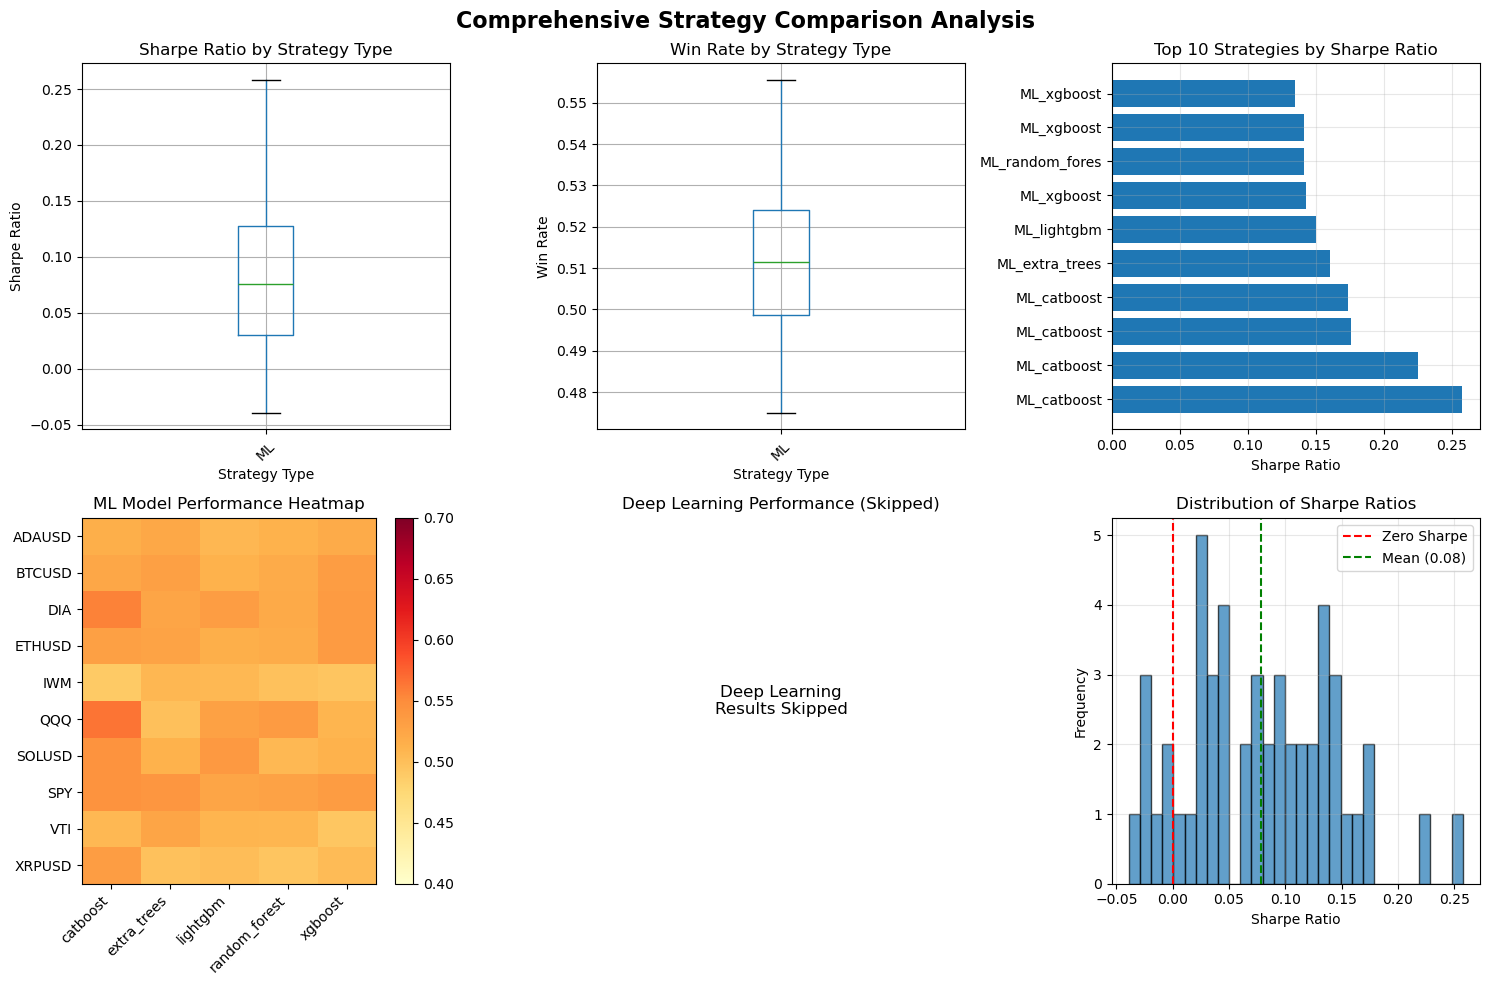

In [9]:
if __name__ == "__main__":
    results_df, returns = main()